<a href="https://colab.research.google.com/github/QueueDoubleU/MLFinalProject/blob/main/SimpleModels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, r2_score


from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# load martin quinn scores
martin_quinn = pd.read_csv('/content/drive/MyDrive/INFO251Final/MartinQuinnScores.csv')

In [ ]:
# create dataframe of cases without transcripts (Cornell convokit)
df_cases = pd.read_csv('/content/drive/MyDrive/INFO251Final/Outcomes_NoTranscript.csv')
#clean unique instance
df_cases['mq_score'] = df_cases['mq_score'].str.replace('0.162.5', '0.162')

#drop cases with -1 as win_side
df_cases = df_cases[df_cases['win_side']!=-1]

<ipython-input-4-243a8a7bd43c>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df_cases['mq_score'] = df_cases['mq_score'].str.replace('0.162.5', '0.162')


In [ ]:
df_cases['mq_score'].unique()

array(['0.559', '0.162', '0.58', '0.643', '0.335', '0.443', '-0.041',
       '-1.079', '-1.133', '-0.707', '-0.56', '-0.414', '-1.043',
       '-0.896', '0.19', '0.381', '0.64', '0.945', '0.609', '0.615',
       '0.492', '0.473', '0.233', '0.156', '0.24', '0.231', '0.266',
       '0.673', '0.877', '0.828', '0.932', '0.878', '0.972', '1.098',
       '0.876', '0.919', '0.756', '0.838', '0.817', '0.736', '0.685',
       '0.782', '0.798', '0.861', '0.849', '0.589', '0.371', '0.26',
       '0.222', '0.11', '0.2705', '0.458', '0.411', '0.576', '0.516',
       '0.577', '0.296', '0.068', '-0.227', '-0.269', '-0.059', '0.298',
       '0.402', '0.355'], dtype=object)

In [ ]:
# error with Wash U data file so we need to find file encoding and add when reading
# commented out because now that it is disocvered, no need to re-run each time

#!pip install chardet

#import chardet    
#rawdata = open('/content/drive/MyDrive/INFO251Final/WashU_onerowpercaseid.csv', 'rb').read()
#result = chardet.detect(rawdata)
#charenc = result['encoding']
#print(charenc)

In [ ]:
# create dataframe from Washington University data
df_wash = pd.read_csv('/content/drive/MyDrive/INFO251Final/WashU_onerowpercaseid.csv', encoding='Windows-1252')

In [ ]:
df_wash.head()

,caseId,docketId,caseIssuesId,voteId,dateDecision,decisionType,usCite,sctCite,ledCite,lexisCite,...,authorityDecision1,authorityDecision2,lawType,lawSupp,lawMinor,majOpinWriter,majOpinAssigner,splitVote,majVotes,minVotes
0,1946-001,1946-001-01,1946-001-01-01,1946-001-01-01-01,11/18/1946,1,329 U.S. 1,67 S. Ct. 6,91 L. Ed. 3,1946 U.S. LEXIS 1724,...,4.0,NaN,6.0,600.0,35 U.S.C. § 33,78.0,78.0,1,8,1
1,1946-002,1946-002-01,1946-002-01-01,1946-002-01-01-01,11/18/1946,1,329 U.S. 14,67 S. Ct. 13,91 L. Ed. 12,1946 U.S. LEXIS 1725,...,4.0,NaN,6.0,600.0,18 U.S.C. § 398,81.0,87.0,1,6,3
2,1946-003,1946-003-01,1946-003-01-01,1946-003-01-01-01,11/18/1946,1,329 U.S. 29,67 S. Ct. 1,91 L. Ed. 22,1946 U.S. LEXIS 3037,...,1.0,NaN,2.0,207.0,NaN,84.0,78.0,1,5,4
3,1946-004,1946-004-01,1946-004-01-01,1946-004-01-01-01,11/25/1946,7,329 U.S. 40,67 S. Ct. 167,91 L. Ed. 29,1946 U.S. LEXIS 1696,...,4.0,NaN,6.0,600.0,49 Stat. 801,87.0,87.0,1,5,3
4,1946-005,1946-005-01,1946-005-01-01,1946-005-01-01-01,11/25/1946,1,329 U.S. 64,67 S. Ct. 154,91 L. Ed. 44,1946 U.S. LEXIS 2997,...,7.0,NaN,NaN,NaN,NaN,78.0,87.0,1,6,3


In [ ]:
#Transform some data to words instead of numerical values?

# Column: Issue Area
# issue area is listed as numerical value but they correspond to different categories
# create dictionary of column integers and corresponding meanings
data_issueArea = ({'Integer Value':[1,2,3,4,5,6,7,8,9,10,11,12,13,14],
                'Issue Area':['Criminal Procedure', 'Civil Rights', 'First Amendment', 'Due Process',
                                      'Privacy', 'Attorneys', 'Unions', 'Economic Activity', 'Judicial Power',
                                      'Federalism', 'Interstate Relations', 'Federal Taxation', 'Miscellaneous',
                                      'Private Action']})
# turn into dataframe
df_issueArea = pd.DataFrame(data_issueArea)
# replace the values in Wash U with the words
df_issueArea.set_index('Integer Value', inplace=True)
df_wash['issueArea'] = df_wash['issueArea'].map(df_issueArea['Issue Area'])
df_issueArea.reset_index(inplace=True)
print(df_wash['issueArea'])






# Column: lcDispositionDirection
# lower court disposition direction is listed as numerical value but they correspond to different categories
# create dictionary of column integers and corresponding meanings
data_lcdd = ({'Integer Value':[1,2,3],
                'direction':['conservative', 'liberal', 'unspecifiable']})

# turn into dataframe
df_lcdd = pd.DataFrame(data_lcdd)
# replace the values in Wash U with the words
df_lcdd.set_index('Integer Value', inplace=True)
df_wash['lcDispositionDirection'] = df_wash['lcDispositionDirection'].map(df_lcdd['direction'])
df_lcdd.reset_index(inplace=True)
print(df_wash['lcDispositionDirection'])


0        Economic Activity
1       Criminal Procedure
2        Economic Activity
3             Civil Rights
4        Economic Activity
               ...        
9155     Economic Activity
9156    Criminal Procedure
9157    Criminal Procedure
9158        Judicial Power
9159          Civil Rights
Name: issueArea, Length: 9160, dtype: object
0       conservative
1       conservative
2            liberal
3            liberal
4            liberal
            ...     
9155    conservative
9156         liberal
9157         liberal
9158    conservative
9159    conservative
Name: lcDispositionDirection, Length: 9160, dtype: object


In [ ]:
df_wash.columns

Index(['caseId', 'docketId', 'caseIssuesId', 'voteId', 'dateDecision',
       'decisionType', 'usCite', 'sctCite', 'ledCite', 'lexisCite', 'term',
       'naturalCourt', 'chief', 'docket', 'caseName', 'dateArgument',
       'dateRearg', 'petitioner', 'petitionerState', 'respondent',
       'respondentState', 'jurisdiction', 'adminAction', 'adminActionState',
       'threeJudgeFdc', 'caseOrigin', 'caseOriginState', 'caseSource',
       'caseSourceState', 'lcDisagreement', 'certReason', 'lcDisposition',
       'lcDispositionDirection', 'declarationUncon', 'caseDisposition',
       'caseDispositionUnusual', 'partyWinning', 'precedentAlteration',
       'voteUnclear', 'issue', 'issueArea', 'decisionDirection',
       'decisionDirectionDissent', 'authorityDecision1', 'authorityDecision2',
       'lawType', 'lawSupp', 'lawMinor', 'majOpinWriter', 'majOpinAssigner',
       'splitVote', 'majVotes', 'minVotes'],
      dtype='object')

In [ ]:
#get only important columns
df_wash_important = df_wash[['caseId', 'issueArea', 'lcDispositionDirection']]

#change case column so it matches df_case
df_wash_important = df_wash_important.rename(columns={'caseId':'case_id'})
df_wash_important['case_id'] = df_wash_important['case_id'].str.replace('-', '_')

df_wash_important.shape

(9160, 3)

In [ ]:
#for df_cases, split the case_id column into two parts at the underscore, and add '0' if necessary
df_cases['case_id'] = df_cases['case_id'].apply(lambda x: '{}_{}'.format(x.split('_')[0], x.split('_')[1].zfill(3)))

#strip down any docket id info from case_id as well
df_cases['case_id'] = df_cases['case_id'].str[:8]

df_cases['case_id'].nunique()

1969

In [ ]:
#merge washington data with original cornell data
df_merged = pd.merge(df_cases, df_wash_important, on='case_id')

#drop where there weren't matches
df_merged = df_merged.dropna(subset=['win_side'])

print(df_merged.head())

   Unnamed: 0 vectors   case_id  \
0           0      []  1955_071   
1           4      []  1955_038   
2           5      []  1955_038   
3           6      []  1955_049   
4           7      []  1955_049   

                                           advocates  win_side  \
0  {'harry_f_murphy': {'side': 1, 'role': 'inferr...       0.0   
1  {'robert_n_gorman': {'side': 3, 'role': 'infer...       0.0   
2  {'robert_n_gorman': {'side': 3, 'role': 'infer...       0.0   
3  {'manfred_w_ehrich_jr': {'side': 3, 'role': 'i...       1.0   
4  {'manfred_w_ehrich_jr': {'side': 3, 'role': 'i...       1.0   

                                          votes_side  convo_id  term  \
0  {'j__john_m_harlan2': 0, 'j__hugo_l_black': 0,...     13127  1955   
1  {'j__john_m_harlan2': 0, 'j__hugo_l_black': 0,...     13016  1955   
2  {'j__john_m_harlan2': 0, 'j__hugo_l_black': 0,...     13043  1955   
3  {'j__john_m_harlan2': 0, 'j__hugo_l_black': 1,...     13106  1955   
4  {'j__john_m_harlan2': 0, 'j__

In [ ]:
df_merged.shape

(1582, 12)

In [ ]:
df_merged.to_csv('/content/drive/MyDrive/INFO251Final/merged_data.csv')

Now that the file is created annd saved, we will begin using it for our models.

In [ ]:
#check dataframe and make sure it is only columns we want to use: Issue Area, Lower Court Disposition Direction, Martin Quinn Score and Win Side
my_data = pd.read_csv('/content/drive/MyDrive/INFO251Final/merged_data.csv')

#get only important columns
#dropping case_id because that shouldn't be relevant in prediction
my_data = my_data[['win_side', 'mq_score', 'issueArea', 'lcDispositionDirection']]

In [ ]:
#deal with categorical data by one hot encoding

x = my_data.drop('win_side', axis=1)
y = my_data['win_side']

# define which columns contain categorical data
categorical_cols = ['issueArea', 'lcDispositionDirection']

# create a transformer to one-hot encode the categorical columns
ct = ColumnTransformer([('one_hot_encoder', OneHotEncoder(), categorical_cols)], remainder='passthrough')

# transform the categorical columns to numerical format
my_x_encoded = ct.fit_transform(x)

In [ ]:
# Split data into training and test
x_train, x_test, y_train, y_test = train_test_split(my_x_encoded, y, shuffle=True, test_size=0.25, random_state=0)
#x_train, y_train = train.drop('win_side', axis=1), train['win_side']
#x_test, y_test = test.drop('win_side', axis=1), test['win_side']

## Logistic Regression

In [ ]:
#for our first logistic regression, we keep our penalization as the default which is L2 (ridge regularization, euclidean distance)

logreg = LogisticRegression(random_state=1).fit(x_train, y_train)

print('Prediction accuracy on the training set: %.3f' % logreg.score(x_train, y_train))
print('Prediction accuracy on the test set: %.3f' % logreg.score(x_test, y_test))

y_pred = logreg.predict(x_test)
collections.Counter(y_pred)

Prediction accuracy on the training set: 0.663
Prediction accuracy on the test set: 0.601


Counter({1.0: 386, 0.0: 10})

While our training set is achieveing 66.3% accuracy, our test set is at 60.1% accurate. 
This is better than randomly guessing but we would like to see if we can improve it. Additionally, we see that predictions are heavily skewed towards predicting 1. 

In [ ]:
#for our next logistic regression, we use L1 penalty (Lasso) to see if we can improve accuracy
#to do this, we also had to switch our solve to liblinear

logreg = LogisticRegression(random_state=1, penalty='l1', solver='liblinear').fit(x_train, y_train)

print('Prediction accuracy on the training set: %.3f' % logreg.score(x_train, y_train))
print('Prediction accuracy on the test set: %.3f' % logreg.score(x_test, y_test))

y_pred = logreg.predict(x_test)
collections.Counter(y_pred)

Prediction accuracy on the training set: 0.661
Prediction accuracy on the test set: 0.604


Counter({1.0: 385, 0.0: 11})

There seems to be little difference between the L1 and L2 regularization in this case. This is what we would expect since we have already manually chosen which features would be influential based on intuition so there are not excess variables to get rid of and change results.

With more time, we may have explored additional features as well but these were mainly built as simple models before putting most effort into the neural networks later.

## Decision Tree

In [ ]:
# Get dummy variables and drop one column
dummy_x = pd.get_dummies(x, columns=['issueArea', 'lcDispositionDirection'], drop_first=True) # Drop a column

In [ ]:
# Split data into training and test
x_train, x_test, y_train, y_test = train_test_split(dummy_x, y, shuffle=True, test_size=0.25, random_state=0)
#x_train, y_train = train.drop('win_side', axis=1), train['win_side']
#x_test, y_test = test.drop('win_side', axis=1), test['win_side']

In [ ]:
print(dummy_x.shape)
print(y.shape)

(1582, 14)
(1582,)


In [ ]:
# Fit model without tuning hyperparameters on held out test set
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, r2_score

model = DecisionTreeClassifier()
model.fit(x_train, y_train)
yhat_train = model.predict(x_train)
yhat_test = model.predict(x_test)

print('Accuracy of training data with no CV: %.2f' % accuracy_score(y_train, yhat_train))
print('Accuracy of test data with no CV: %.2f' % accuracy_score(y_test, yhat_test))
collections.Counter(yhat_test)

Accuracy of training data with no CV: 0.75
Accuracy of test data with no CV: 0.63


Counter({1.0: 282, 0.0: 114})

We see an improvement here over logistic regression. Even though we are achieving the same 63% accuracy as the "always guess petitioner" baseline, our prediction shows that we are givig a distribution of both 1 and 0. This shows that there is some complexity behind our strategy rather than defaulting to 1.  


Since our training data seems to be higher than our test data, it suggests that we may be overfitting. We will build a random forest and then tune hyperparamters.

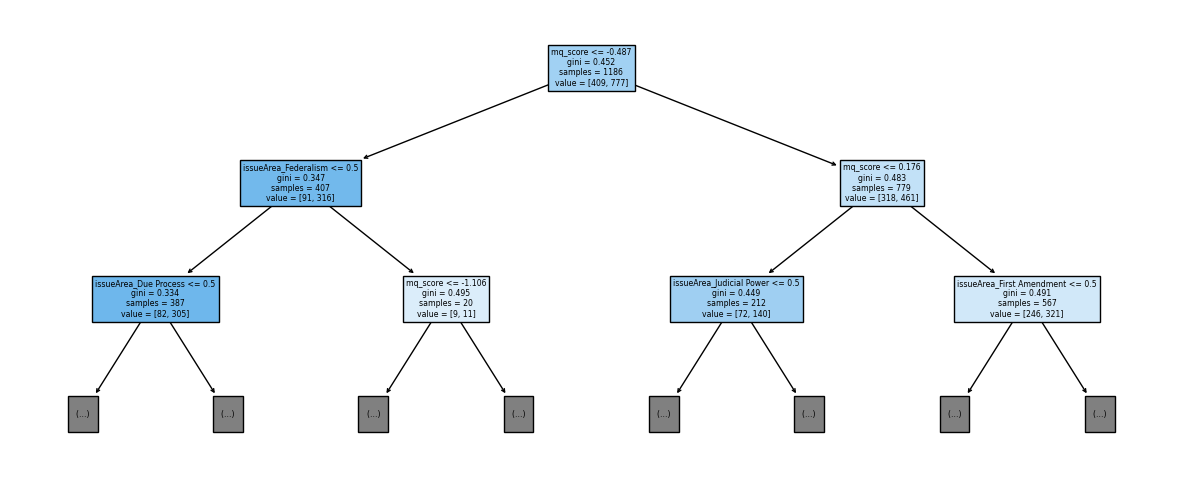

In [ ]:
#Diagram of the tree
from sklearn import tree

plt.figure(figsize=(15,6))
my_tree = tree.plot_tree(model, feature_names=x_train.columns, filled=True, max_depth=2)

## Random Forest

In [ ]:
#Now, random forest with dummy
# Fit model without tuning hyperparameters
model = RandomForestClassifier(n_estimators=100, random_state=2)
model.fit(x_train, y_train)
yhat_train = model.predict(x_train)
yhat_test = model.predict(x_test)

print('Accuracy (train): %.2f' % accuracy_score(y_train, yhat_train))
print('Accuracy (test): %.2f' % accuracy_score(y_test, yhat_test))
print(collections.Counter(yhat_test))

print('Precision (train): %.2f' % recall_score(y_train, yhat_train))
print('Precision (test): %.2f' % recall_score(y_test, yhat_test))

print('Recall (train): %.2f' % precision_score(y_train, yhat_train))
print('Recall (test): %.2f' % precision_score(y_test, yhat_test))

Accuracy (train): 0.75
Accuracy (test): 0.64
Counter({1.0: 299, 0.0: 97})
Precision (train): 0.89
Precision (test): 0.83
Recall (train): 0.76
Recall (test): 0.67


Moving from decision tree to random forest, we see a very slight improvement on test accuracy (increase by 0.01). We will now tune hyperparameters.

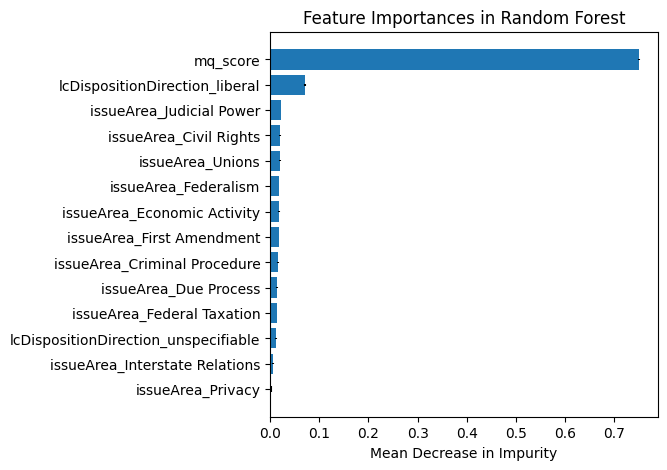

In [ ]:
# Get feature importances
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
importances = pd.DataFrame([x_train.columns, importances]).T
importances.columns = ['Feature', 'Importance']
importances = importances.sort_values('Importance', ascending=True)

# Bar chart
fig, ax = plt.subplots(1, figsize=(5, 5))
plt.barh(importances['Feature'], importances['Importance'], yerr=std)
ax.set_xlabel('Mean Decrease in Impurity')
ax.set_title('Feature Importances in Random Forest')
plt.show()

## Tuning Random Forest

In [ ]:
# Tune hyperparameters: max_depth, n_estimators
model = RandomForestClassifier(random_state=1)
cv = KFold(n_splits=3, shuffle=True, random_state=1)
params = {'max_depth':[2, 4, 6, 8], 'n_estimators':[25, 50, 100, 200, 1000]}
#params = {'max_depth':[100, 200, 300], 'n_estimators':[25, 50, 100, 200, 1000]}
cv_model = GridSearchCV(model, param_grid=params, scoring='accuracy', refit=True, return_train_score=True, cv=cv)
cv_model.fit(x_train, y_train)
model = cv_model.best_estimator_
model.fit(x_train, y_train)
yhat_train = model.predict(x_train)
yhat_test = model.predict(x_test)

print('Best maximum depth: %i' % cv_model.best_params_['max_depth'])
print('Best number of estimators: %i' % cv_model.best_params_['n_estimators'])

print('Accuracy (train): %.2f' % accuracy_score(y_train, yhat_train))
print('Accuracy (test): %.2f' % accuracy_score(y_test, yhat_test))
print(collections.Counter(yhat_test))

print('Precision (train): %.2f' % recall_score(y_train, yhat_train))
print('Precision (test): %.2f' % recall_score(y_test, yhat_test))

print('Recall (train): %.2f' % precision_score(y_train, yhat_train))
print('Recall (test): %.2f' % precision_score(y_test, yhat_test))

Best maximum depth: 6
Best number of estimators: 25
Accuracy (train): 0.69
Accuracy (test): 0.62
Counter({1.0: 373, 0.0: 23})
Precision (train): 0.97
Precision (test): 0.97
Recall (train): 0.69
Recall (test): 0.62


When tuning hyperparameters, we ended up getting lower accuracy for both train and test accuracy. 

Also, takng a look at our predictions, we see the model has learned to predict 1 (the petitioner wins) much more often. This suggests that with less depth for branched decision making, it is defaulting to this simplification more often. 

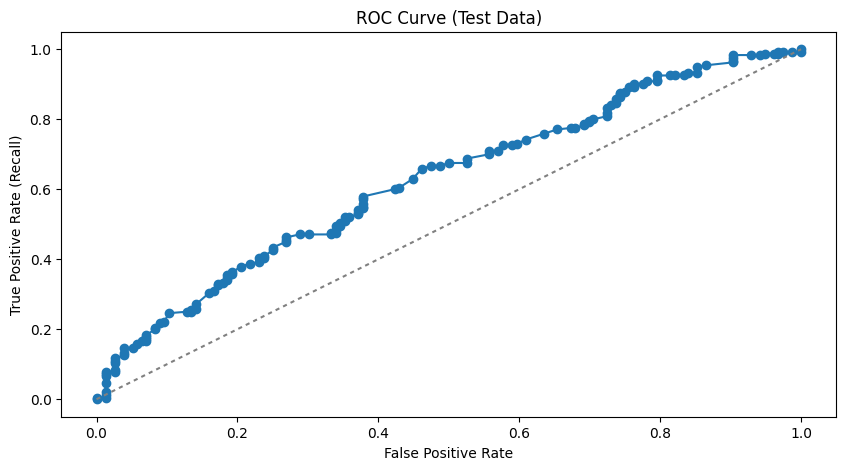

In [ ]:
# ROC Curve
yhat_test_proba = model.predict_proba(x_test)[:, 1]
fprs, tprs, thresholds = roc_curve(y_test, yhat_test_proba)

fig, ax = plt.subplots(1, figsize=(10, 5))
ax.scatter(fprs, tprs)
ax.plot(fprs, tprs)
ax.plot([0, 1], [0, 1], color='grey', dashes=[2, 2])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate (Recall)')
ax.set_title('ROC Curve (Test Data)')
plt.show()

In [ ]:
# Get area under the curve
print('AUC score: %.2f' % roc_auc_score(y_test, yhat_test_proba))

AUC score: 0.63


In [ ]:
# Get "optimal" threshold: the one closest to the top-left corner of the ROC graph
distances_from_top_left = [np.sqrt(tprs[i]**2 + (1-fprs[i])**2) for i in range(len(tprs))]
best_cutoff = np.argmin(distances_from_top_left)
print('Threshold closest to top-left corner of graph: %.2f (%.2f TPR, %.2f FPR)' % 
      (thresholds[best_cutoff], tprs[best_cutoff], fprs[best_cutoff]))

Threshold closest to top-left corner of graph: 0.67 (0.47 TPR, 0.34 FPR)


We will also run AdaBoost to see how results may vary.

In [ ]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier

In [ ]:
# Tune hyperparameters: n_estimators
model = AdaBoostClassifier(random_state=0)
cv = KFold(n_splits=3, shuffle=True, random_state=1)
params = {'n_estimators':[1, 5, 10, 25, 50, 100, 200, 500]}
cv_model = GridSearchCV(model, param_grid=params, scoring='accuracy', refit=True, return_train_score=True, cv=cv)
cv_model.fit(x_train, y_train)
model = cv_model.best_estimator_
model.fit(x_train, y_train)
yhat_train = model.predict(x_train)
yhat_test = model.predict(x_test)

print('Best number of estimators: %i' % cv_model.best_params_['n_estimators'])

print('Accuracy (train): %.2f' % accuracy_score(y_train, yhat_train))
print('Accuracy (test): %.2f' % accuracy_score(y_test, yhat_test))

print('Precision (train): %.2f' % recall_score(y_train, yhat_train))
print('Precision (test): %.2f' % recall_score(y_test, yhat_test))

print('Recall (train): %.2f' % precision_score(y_train, yhat_train))
print('Recall (test): %.2f' % precision_score(y_test, yhat_test))

Best number of estimators: 50
Accuracy (train): 0.67
Accuracy (test): 0.59
Precision (train): 0.93
Precision (test): 0.90
Recall (train): 0.68
Recall (test): 0.61


In [ ]:
import collections
collections.Counter(yhat_test)

Counter({1.0: 354, 0.0: 42})

Overall, our best model, on the basis of testing accuracy, came from the random forest with 100 estimators and no max depth set. This model achieved 64% accuracy which is only slightly higher than "guess petitioner wins every time" baseline. In our next portion, we will begin more complex models through the use of various neural networks. 